### Import Libraries

In [1]:
from huggingface_hub import notebook_login
from datasets import list_datasets
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import pandas as pd
import torch
import numpy as np
from umap import UMAP

In [2]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer.vocab_size

c:\Users\csang\miniconda3\envs\NLPBASICS\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


30522

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

### Erster Blick in die Daten

In [4]:
all_datasets = list_datasets()
print(f"Derzeit sind {len(all_datasets)} Datensätze auf dem Hugging Face Hub verfügbar")
print(f"Die ersten 10 Datensätze sind: {all_datasets[:10]}")

C:\Users\csang\AppData\Local\Temp\ipykernel_13100\3505647632.py:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


Derzeit sind 141099 Datensätze auf dem Hugging Face Hub verfügbar
Die ersten 10 Datensätze sind: ['acronym_identification', 'ade_corpus_v2', 'UCLNLP/adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'allenai/ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [5]:
emotions = load_dataset("emotion")
emotions

c:\Users\csang\miniconda3\envs\NLPBASICS\Lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
len(train_ds)
print(f"Der Datensatz enthält {len(train_ds)} Beispiele")
print(f"Das erste Beispiel ist: {train_ds[0]}")
print(f"Colums: {train_ds.column_names}")
print(f"Features: {train_ds.features}")

Der Datensatz enthält 16000 Beispiele
Das erste Beispiel ist: {'text': 'i didnt feel humiliated', 'label': 0}
Colums: ['text', 'label']
Features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [8]:
print(f"Die ersten 5 Beispiele sind: {train_ds[:5]}")
print(f"Die ersten 5 Labels sind: {train_ds['label'][:5]}")
print(f"Die ersten 5 Texte sind: {train_ds['text'][:5]}")

Die ersten 5 Beispiele sind: {'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}
Die ersten 5 Labels sind: [0, 0, 3, 2, 3]
Die ersten 5 Texte sind: ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


### Dataset-Objekte in DataFrames überführen

In [9]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [10]:
def label_to_string(label):
    return emotions["train"].features["label"].int2str(label)

df["label_name"] = df["label"].apply(label_to_string)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Blick in die Verteilung der Kateogrien

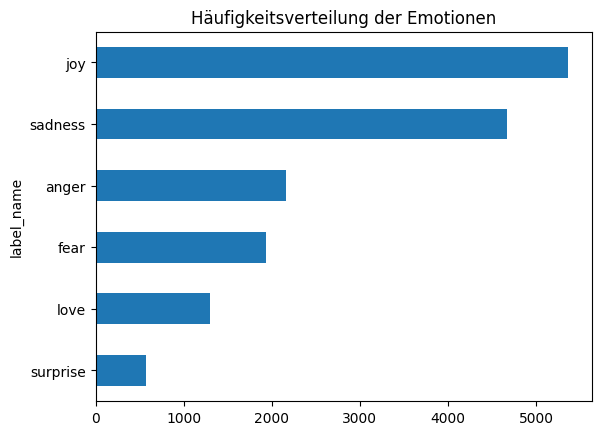

In [11]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Häufigkeitsverteilung der Emotionen")
plt.show()

### Wie lange sind unsere Tweets?

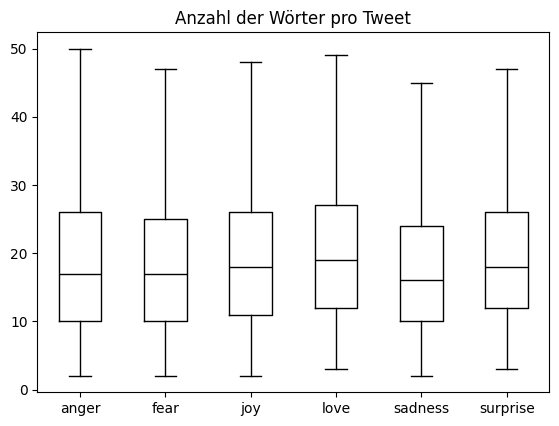

In [12]:
df["Anzahl der Wörter pro Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Anzahl der Wörter pro Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [13]:
emotions.reset_format()

### Den gesamten Datensatz tokenisieren

In [14]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize(emotions["train"][:2]))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [15]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [16]:
print(emotions_encoded["train"][:1])
print(emotions_encoded["train"].column_names)

{'text': ['i didnt feel humiliated'], 'label': [0], 'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}
['text', 'label', 'input_ids', 'attention_mask']


### Die letzten verborgenen Zustände extrahieren

In [17]:
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_states = model(**inputs).last_hidden_state
    return {"hidden_states": last_hidden_states[:, 0].cpu().numpy()}

In [18]:
emotions_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=16)

In [19]:
emotions_hidden["train"][:1]
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_states']

### Feature Matrix erstellen

In [20]:
X_train = np.array(emotions_hidden["train"]["hidden_states"])
X_valid = np.array(emotions_hidden["validation"]["hidden_states"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((16000, 768), (2000, 768), (16000,), (2000,))

### Trainingsdatensatz visualisieren

In [21]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

df_emb = pd.DataFrame(mapper.transform(X_scaled), columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.374602,6.276818,0
1,-3.089010,5.402227,0
2,5.310815,2.627412,3
3,-2.346835,3.471262,2
4,-3.421992,3.396195,3


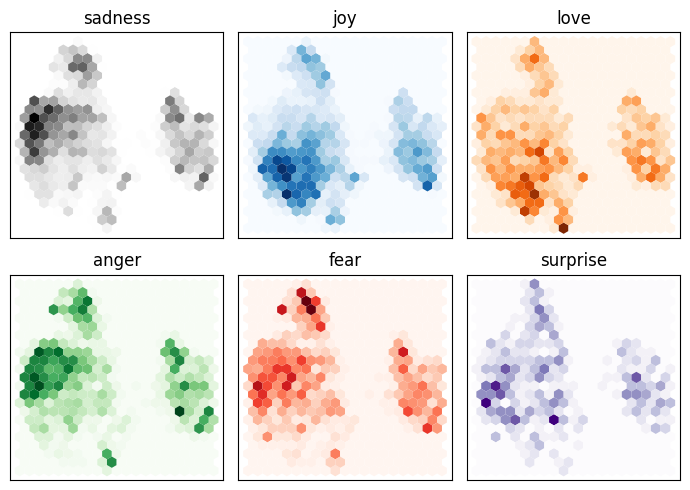

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps= ["Greys", "Blues", "Oranges", "Greens", "Reds", "Purples"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels,cmaps)):
    df_emb_sub = df_emb[df_emb["label"] == i]
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], gridsize=20, cmap=cmap, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

### Einen einfachen Klassifikator trainieren

In [23]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.634

In [24]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

### Konfusionsmatrix

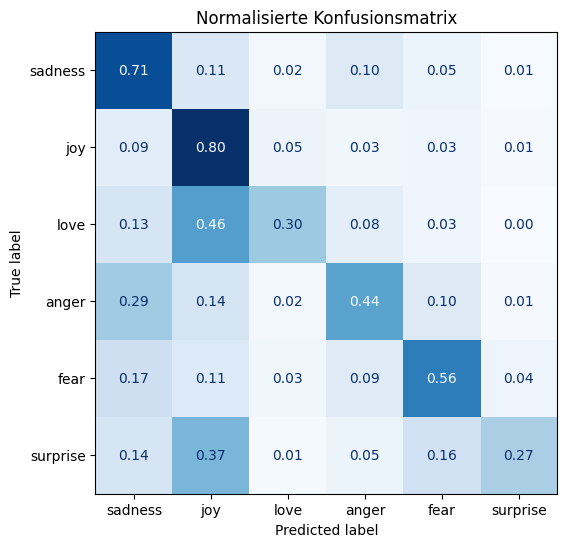

In [25]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalisierte Konfusionsmatrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Feintuning des Modells

### Ein vortrainiertes Modell verwenden

In [26]:
num_labels = 6
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt, num_labels=num_labels)
        .to(device))

c:\Users\csang\miniconda3\envs\NLPBASICS\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Qualitätsmasse festlegen

In [27]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"f1": f1, "accuracy": acc}

### Modell trainieren

In [30]:
notebook_login()

In [31]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotions"
training_args = TrainingArguments(output_dir=model_name,
                                    num_train_epochs=2,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    logging_steps=logging_steps,
                                    evaluation_strategy="epoch",
                                    disable_tqdm=False,
                                    push_to_hub=True,
                                    save_strategy="epoch",
                                    load_best_model_at_end=True,
                                    log_level="error")

In [32]:
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics,
                    train_dataset=emotions_encoded["train"],
                    eval_dataset=emotions_encoded["validation"],
                    tokenizer=tokenizer)
trainer.train()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fehleranalyse

In [ ]:
def forward_pass_with_label(batch):
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        outputs = model(**inputs)
        pred_label = torch.argmax(outputs.logits, axis=-1)
        loss = cross_entropy(outputs.logits, batch["label"].to(device), reduction="none")
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [ ]:
emotions_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

emotions_enocded["validation"]= emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

In [ ]:
emotions_encoded.set_format(type="pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_to_string)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_to_string)

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)